C:\Users\david\AppData\Local\Temp\ipykernel_33388\704500723.py:42: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_raw = pd.read_sql(query, conn)
C:\Users\david\AppData\Local\Temp\ipykernel_33388\704500723.py:123: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_piv


Scores guardados en: ./scores_emisiones_tempVAR_deltaExtremos_norm.csv
Países con score: 197


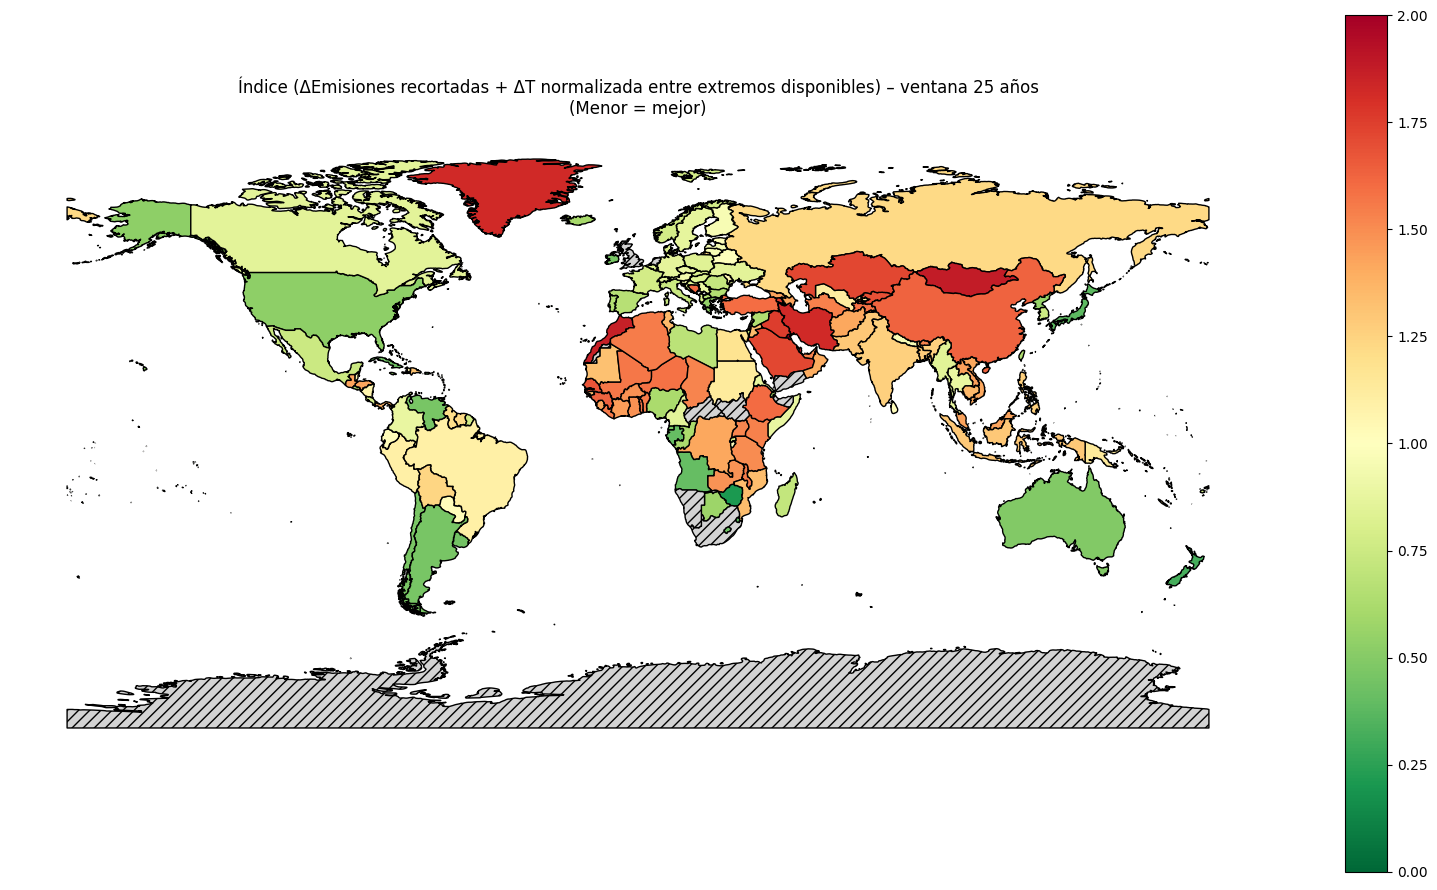

In [14]:
import os
import numpy as np
import pandas as pd
import pymysql
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
from dotenv import load_dotenv

# ========== Parámetros ==========
N = 25          # ventana de años
CLIP = True     # recortar E_frac a [0,1]
SHAPEFILE = "./../../data/visualizacion/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp"

TEMP_VAR_CODE = "temperaturas"   # ΔT anual (variación)
EMISS_CODE    = "emision_co2"        # emisiones

# ========== DB connect ==========
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# ==============================
# 1) Traer emisiones + temperatura (solo variación)
# ==============================
query = f"""
SELECT 
    h.anio                         AS Year,
    p.codigo                       AS iso2,
    p.nombre                       AS pais_nombre,
    i.codigo                       AS indicador_codigo,
    h.valor                        AS valor
FROM hechos h
JOIN paises p      ON p.codigo = h.pais_id
JOIN indicadores i ON i.id = h.indicador_id
WHERE i.codigo IN ('{EMISS_CODE}', '{TEMP_VAR_CODE}')
"""
df_raw = pd.read_sql(query, conn)

# ==============================
# 2) Preparar y pivotar
# ==============================
df = df_raw.copy()
df["Year"] = df["Year"].astype(int)

df_piv = df.pivot_table(
    index=["Year", "iso2", "pais_nombre"],
    columns="indicador_codigo",
    values="valor",
    aggfunc="mean"
).reset_index()

# Renombrar columnas
col_map = {}
if EMISS_CODE in df_piv.columns: col_map[EMISS_CODE] = "Emisiones"
if TEMP_VAR_CODE in df_piv.columns: col_map[TEMP_VAR_CODE] = "TempVar"
df_piv.rename(columns=col_map, inplace=True)

# Necesitamos al menos alguna observación en cada variable
df_piv = df_piv.sort_values(["iso2", "Year"])

def clip01(x): 
    return max(0.0, min(1.0, x))

# ==============================
# 3) Cálculo por país (primer/último disponible en ventana)
# ==============================
def compute_components_for_country(g):
    g = g.sort_values("Year")
    if g.empty:
        return pd.Series({"E_frac": np.nan, "DeltaT_net": np.nan, "YearStart": np.nan, "YearEnd": np.nan})
    
    y_end_global = g["Year"].max()
    y_start = y_end_global - (N - 1)
    win = g[g["Year"].between(y_start, y_end_global)].copy()
    if win.empty:
        return pd.Series({"E_frac": np.nan, "DeltaT_net": np.nan, "YearStart": y_start, "YearEnd": y_end_global})

    # ---- años disponibles en la ventana
    years_available = sorted(win["Year"].unique())
    if len(years_available) < 2:
        # Necesitamos al menos dos años para diferencias
        return pd.Series({"E_frac": np.nan, "DeltaT_net": np.nan, "YearStart": y_start, "YearEnd": y_end_global})

    y_first = years_available[0]
    y_last  = years_available[-1]

    # ---- Emisiones: usar primer y último año DISPONIBLES en la ventana
    E0 = win.loc[win["Year"] == y_first, "Emisiones"].mean()
    E1 = win.loc[win["Year"] == y_last,  "Emisiones"].mean()
    if pd.isna(E0) or E0 == 0 or pd.isna(E1):
        e_frac = np.nan
    else:
        e_frac = (E1 - E0) / E0
        if CLIP:
            e_frac = clip01(e_frac)

    # ---- Temperatura (datos ya son variaciones): Tfin - Tini = suma ΔT entre y_first..y_last
    # Tomamos todas las TempVar de la ventana disponible
    if "TempVar" in win.columns and win["TempVar"].notna().any():
        win_temp = win.dropna(subset=["TempVar"])
        # Nos aseguramos de sumar solo entre y_first..y_last
        win_temp = win_temp[win_temp["Year"].between(y_first, y_last)]
        if win_temp["Year"].nunique() >= 1:
            delta_t_net = win_temp["TempVar"].sum()
        else:
            delta_t_net = np.nan
    else:
        delta_t_net = np.nan

    return pd.Series({
        "E_frac": e_frac,
        "DeltaT_net": delta_t_net,
        "YearStart": y_first,     # primeros/últimos DISPONIBLES
        "YearEnd": y_last
    })

df_comp = (
    df_piv
    .groupby(["iso2", "pais_nombre"], as_index=False)
    .apply(compute_components_for_country)
)

# ==============================
# 4) Filtrar válidos y normalizar ΔT_net (min–max 0..1)
# ==============================
df_valid = df_comp.dropna(subset=["E_frac", "DeltaT_net"]).copy()

min_t = df_valid["DeltaT_net"].min()
max_t = df_valid["DeltaT_net"].max()
den = max_t - min_t
df_valid["Temp_norm_0_1"] = 0.5 if den == 0 else (df_valid["DeltaT_net"] - min_t) / den

# ==============================
# 5) Score final (0..2) y export
# ==============================
df_valid["Score"] = df_valid["E_frac"] + df_valid["Temp_norm_0_1"]
df_valid["Score_0_100"] = 50 * df_valid["Score"]

# ISO2 -> ISO3 para mapa
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

df_valid["iso_a3"] = df_valid["iso2"].apply(iso2_to_iso3)
df_scores = df_valid[df_valid["iso_a3"].notna()].copy()
df_scores["iso_a3"] = df_scores["iso_a3"].str.upper()

out_csv = "./scores_emisiones_tempVAR_deltaExtremos_norm.csv"
df_scores.to_csv(out_csv, index=False)
print(f"Scores guardados en: {out_csv}")
print("Países con score:", df_scores.shape[0])

# ==============================
# 6) Mapa mundial (merge robusto + verde→rojo)
# ==============================
world = gpd.read_file(SHAPEFILE)

# Clave estable del shapefile
shape_key_candidates = ["ADM0_A3", "ISO_A3_EH", "ISO_A3"]
for k in shape_key_candidates:
    if k in world.columns:
        shape_key = k
        break
world[shape_key] = world[shape_key].astype(str).str.upper()

map_data = world.merge(df_scores, left_on=shape_key, right_on="iso_a3", how="left")

fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(
    f"Índice (ΔEmisiones recortadas + ΔT normalizada entre extremos disponibles) – ventana {N} años\n(Menor = mejor)",
    pad=12
)

map_data.plot(
    column="Score",
    legend=True,
    ax=ax,
    edgecolor="black",
    cmap="RdYlGn_r",
    vmin=0, vmax=2,
    missing_kwds={"color": "lightgrey", "hatch": "///", "label": "Sin datos"}
)

ax.axis("off")
plt.tight_layout()
plt.show()


Filas del CSV sin match en shapefile: 5


,iso2,pais_nombre,iso_a3
66,GI,Gibraltar,GIB
70,GP,Guadalupe,GLP
64,GF,Guayana Francesa,GUF
121,MQ,Martinica,MTQ
151,RE,Reunión,REU


FRA en mapa:     pais_nombre     Score
160     Francia  0.689097
NOR en mapa:    pais_nombre     Score
88     Noruega  0.026493


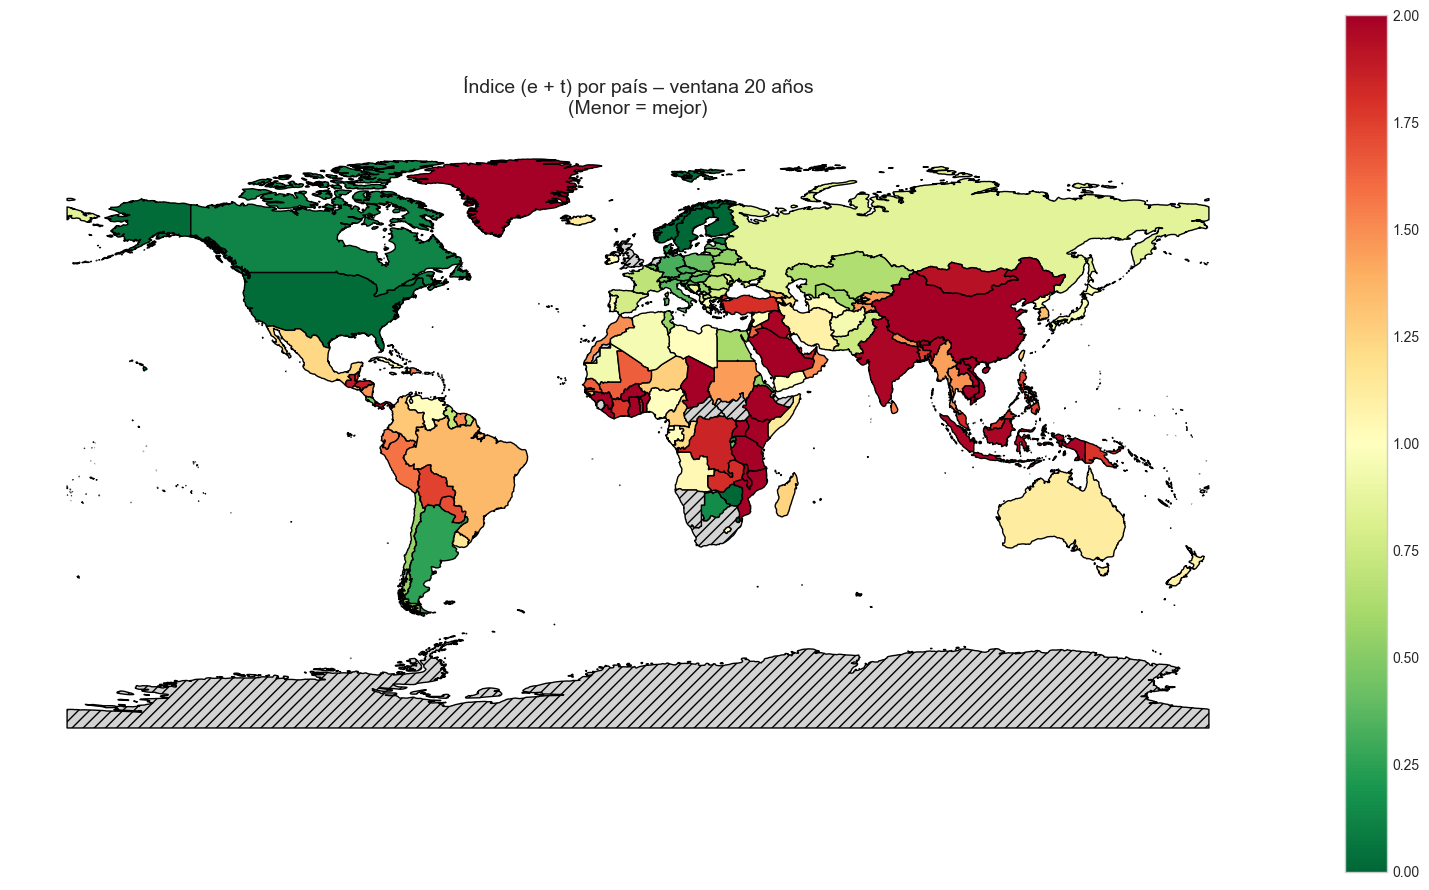

In [6]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# -------------------------------------
# 1) Cargar shapefile y elegir la clave
# -------------------------------------
world = gpd.read_file(SHAPEFILE)

# Selecciona la mejor columna disponible como clave del shapefile
shape_key_candidates = ["ADM0_A3", "ISO_A3_EH", "ISO_A3"]
for k in shape_key_candidates:
    if k in world.columns:
        shape_key = k
        break

world[shape_key] = world[shape_key].astype(str).str.upper()

# -------------------------------------
# 2) Normalizar códigos del CSV
# -------------------------------------
df_scores["iso_a3"] = df_scores["iso_a3"].astype(str).str.upper()

# Parches típicos (ajusta si ves más en el anti-join)
patch = {
    # ejemplos: "XK"->"XKX", "UK"->"GBR", etc. Si aplica en tu CSV:
    "XK": "XKX",   # Kosovo, si alguna vez lo tuvieras como ISO2->ISO3 mal mapeado
    # Nada especial para NOR/FRA, pero lo dejamos por si futuros casos:
    "FR": "FRA",
    "NO": "NOR",
}
df_scores["iso_a3"] = df_scores["iso_a3"].replace(patch)

# -------------------------------------
# 3) Diagnóstico: ¿quién no casa?
# -------------------------------------
world_codes = set(world[shape_key].unique())
missing = (
    df_scores[~df_scores["iso_a3"].isin(world_codes)]
    [["iso2","pais_nombre","iso_a3"]]
    .drop_duplicates()
    .sort_values("pais_nombre")
)
print("Filas del CSV sin match en shapefile:", len(missing))
display(missing.head(50))

# -------------------------------------
# 4) Hacer el merge robusto
# -------------------------------------
map_data = world.merge(df_scores, left_on=shape_key, right_on="iso_a3", how="left")

# -------------------------------------
# 5) Comprobar explícitamente FRA y NOR
# -------------------------------------
print("FRA en mapa:", map_data.loc[map_data[shape_key]=="FRA", ["pais_nombre","Score"]].head(3))
print("NOR en mapa:", map_data.loc[map_data[shape_key]=="NOR", ["pais_nombre","Score"]].head(3))

# -------------------------------------
# 6) Pintar (verde -> rojo, 0..2)
# -------------------------------------
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title(f"Índice (e + t) por país – ventana {N} años\n(Menor = mejor)", pad=12)

map_data.plot(
    column="Score",
    legend=True,
    ax=ax,
    edgecolor="black",
    cmap="RdYlGn_r",
    vmin=0, vmax=2,
    missing_kwds={"color":"lightgrey","hatch":"///","label":"Sin datos"}
)

ax.axis("off")
plt.tight_layout()
plt.show()


RESULTADOS GRAFICAS SIMPLES

C:\Users\david\AppData\Local\Temp\ipykernel_33388\2091731564.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


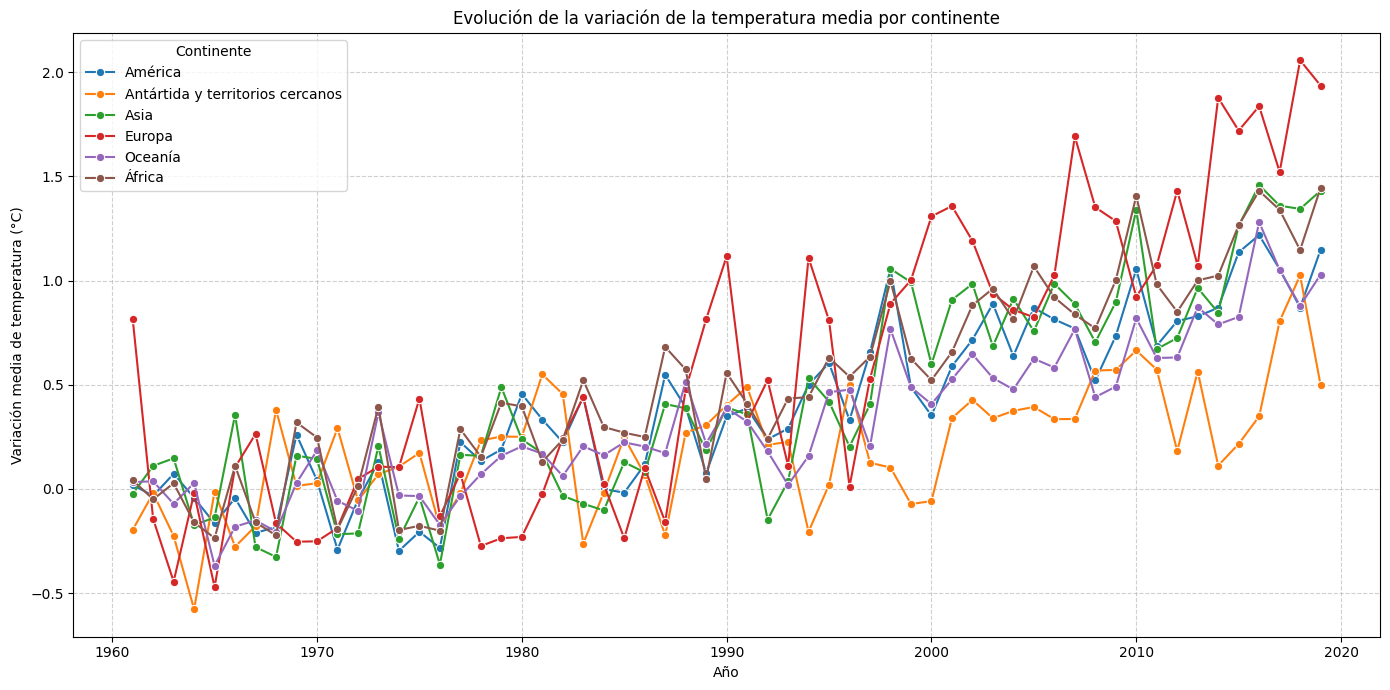

In [8]:
import os
import pandas as pd
import pymysql
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# ======================
# Configuración
# ======================
load_dotenv()
conn = pymysql.connect(
    host=os.getenv('DB_HOST'),
    user=os.getenv('DB_USER'),
    password=os.getenv('DB_PASSWORD'),
    database=os.getenv('DB_NAME')
)

# ======================
# 1) Query a la BD
# ======================
query = """
SELECT 
    h.anio,
    c.nombre AS continente,
    AVG(h.valor) AS temp_var_media
FROM hechos h
JOIN paises p      ON h.pais_id = p.codigo
JOIN continentes c ON p.continente_id = c.id
JOIN indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'temperaturas'
GROUP BY h.anio, c.nombre
ORDER BY h.anio, c.nombre;
"""

df = pd.read_sql(query, conn)

# ======================
# 2) Preparar datos
# ======================
# Calcular media de la variación de temperatura por año y continente
df_grouped = (
    df.groupby(["anio", "continente"])["temp_var_media"]
    .mean()
    .reset_index()
)

# ======================
# 3) Gráfica de líneas
# ======================
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=df_grouped,
    x="anio",
    y="temp_var_media",
    hue="continente",
    marker="o"
)

plt.title("Evolución de la variación de la temperatura media por continente")
plt.xlabel("Año")
plt.ylabel("Variación media de temperatura (°C)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Continente")
plt.tight_layout()
plt.show()


GRAFICA EVOLUCION DE EMISIONES

C:\Users\david\AppData\Local\Temp\ipykernel_33388\1098107456.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


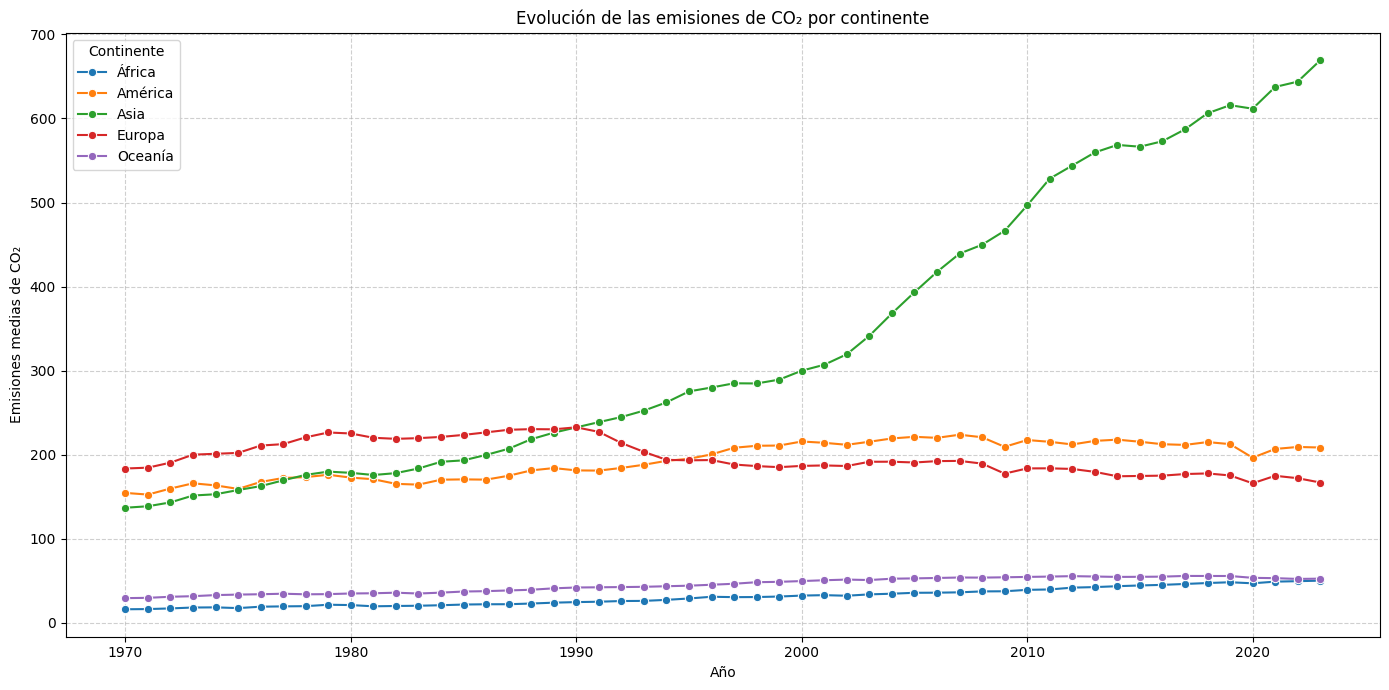

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

query = """
SELECT 
    h.anio,
    c.nombre AS continente,
    AVG(h.valor) AS emisiones_media
FROM hechos h
JOIN paises p      ON h.pais_id = p.codigo
JOIN continentes c ON p.continente_id = c.id
JOIN indicadores i ON h.indicador_id = i.id
WHERE i.codigo = 'emision_co2'
GROUP BY h.anio, c.nombre
ORDER BY h.anio, c.nombre;
"""

df = pd.read_sql(query, conn)

plt.figure(figsize=(14,7))
sns.lineplot(
    data=df,
    x="anio",
    y="emisiones_media",
    hue="continente",
    marker="o"
)

plt.title("Evolución de las emisiones de CO₂ por continente")
plt.xlabel("Año")
plt.ylabel("Emisiones medias de CO₂")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Continente")
plt.tight_layout()
plt.show()
